# Import Dataset

In [25]:
# from google.colab import drive
# drive.mount("/content/drive")
# !ls "/content/drive/My Drive/Dataset"

# Splitting Dataset

In [50]:
import os
base_dir = "./Dataset"
folder_names = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

# Directory with training cat/dog pictures
dataset_dir = []
for folder in folder_names:
    dataset_dir.append(os.path.join(base_dir, folder))

In [51]:
import os
import shutil
import random

def split_dataset(input_dir, output_dir, train_split=0.7, val_split=0.3):
    # Membuat direktori untuk set train dan val
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Membuat direktori untuk setiap kategori
    for category in folder_names:
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        # Mendapatkan daftar nama file dalam setiap kategori
        category_dir = os.path.join(input_dir, category)
        files = os.listdir(category_dir)
        random.shuffle(files)

        # Menghitung jumlah file untuk set train dan val
        num_train = int(len(files) * train_split)
        num_val = len(files) - num_train

        # Memindahkan file ke set train dan val
        for file in files[:num_train]:
            src = os.path.join(category_dir, file)
            dst = os.path.join(train_dir, category, file)
            shutil.copy(src, dst)
        for file in files[num_train:]:
            src = os.path.join(category_dir, file)
            dst = os.path.join(val_dir, category, file)
            shutil.copy(src, dst)

# Contoh penggunaan
input_dir = './Dataset' 
output_dir = './SplitDataset'
# os.makedirs(output_dir, exist_ok=True)
# split_dataset(input_dir, output_dir)

In [52]:
# Cek jumlah split untuk Astricitoma pada folder train dan val dan bandingkan dngan folder awal
normal_path = "./Dataset/_NORMAL T1"
train_path  = "./SplitDataset/train/_NORMAL T1"
val_path    = "./SplitDataset/val/_NORMAL T1"

print(f"Banyak Data Normal : {len(os.listdir(normal_path))}")
print(f"Banyak Data Train  : {len(os.listdir(train_path))}")
print(f"Banyak Data Val    : {len(os.listdir(val_path))}")

Banyak Data Normal : 251
Banyak Data Train  : 175
Banyak Data Val    : 76


# Image Augmentation

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

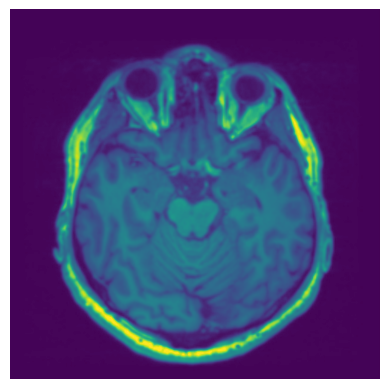

In [4]:
# Open the image file
image = Image.open('./SplitDataset/train/_NORMAL T1/0a0bc6879f5d5d14c4df229b64b801_big_gallery.jpeg')

# Convert the image to a NumPy array
image_np = np.array(image)

# Membuat gambar menggunakan Matplotlib
plt.figure()
plt.imshow(image_np)
plt.axis('off')
plt.show()

## Shear

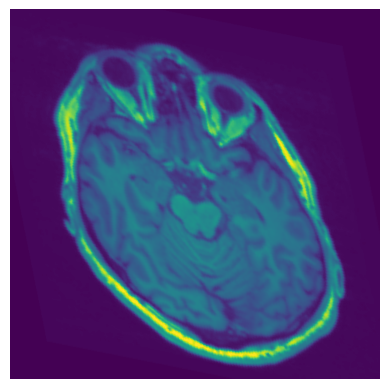

In [65]:
import numpy as np

def shear_image(image, shear_factor_x, shear_factor_y):
    height, width = image.shape
    
    sheared_image = np.zeros_like(image)
    
    # koordinat tengah gambar
    center_x, center_y = width // 2, height // 2

    # matrix shear
    shear_matrix = np.array([
        [1, shear_factor_x],
        [shear_factor_y, 1]
    ], dtype=np.float32)

    for x in range(width):
        for y in range(height):
            # pindah origin ke tengah
            new_x = x - center_x
            new_y = y - center_y
            
            # terapkan transformasi
            new_coords = np.dot([new_x, new_y], shear_matrix)
            sheared_x, sheared_y = new_coords
            
            # kembalikan origin
            sheared_x = int(sheared_x + center_y)
            sheared_y = int(sheared_y + center_x)
            
            # terapkan pixel jika masih di dalam frame gambar
            if 0 <= sheared_x < width and 0 <= sheared_y < height:
                sheared_image[sheared_x, sheared_y] = image[x, y]
    
    return sheared_image

sheared_image = shear_image(image_np, 0.2, 0.2)

plt.figure()
plt.imshow(sheared_image)
plt.axis('off')
plt.show()

## Scaling

In [5]:
def scale_image(image_array, scale_x, scale_y):
    """
    Scale an image using matrix multiplication.
    
    Parameters:
    image_array (numpy.ndarray): Input image as a numpy array.
    scale_x (float): Scaling factor in the horizontal direction.
    scale_y (float): Scaling factor in the vertical direction.
    
    Returns:
    numpy.ndarray: Scaled image.
    """
    if scale_x == 1 and scale_y == 1:
        return image_array.copy()  # Return the original image if no scaling is applied
    
    original_height, original_width = image_array.shape[:2]
    
    # Determine the coordinates of the center point of the image
    center_x = original_width / 2
    center_y = original_height / 2
    
    # Translate the center point to the origin (0, 0)
    translate_matrix = np.array([[1, 0, -center_x],
                                 [0, 1, -center_y],
                                 [0, 0, 1]])
    
    # Create the scaling transformation matrix
    scale_matrix = np.array([[scale_x, 0, 0],
                             [0, scale_y, 0],
                             [0, 0, 1]])
    
    # Translate the center point back to its original position
    translate_back_matrix = np.array([[1, 0, center_x],
                                      [0, 1, center_y],
                                      [0, 0, 1]])
    
    # Combined transformation matrix
    transform_matrix = translate_back_matrix @ scale_matrix @ translate_matrix
    
    # Apply the transformation
    if image_array.ndim == 2:  # Grayscale image
        scaled_image = np.zeros((original_height, original_width), dtype=image_array.dtype)
    else:  # RGB image
        scaled_image = np.zeros((original_height, original_width, image_array.shape[2]), dtype=image_array.dtype)
    
    # Apply the transformation
    for i in range(original_height):
        for j in range(original_width):
            original_coords = np.linalg.inv(transform_matrix) @ np.array([j, i, 1])
            original_x, original_y = int(original_coords[0]), int(original_coords[1])
            
            if 0 <= original_x < original_width and 0 <= original_y < original_height:
                scaled_image[i, j] = image_array[original_y, original_x]
    
    return scaled_image

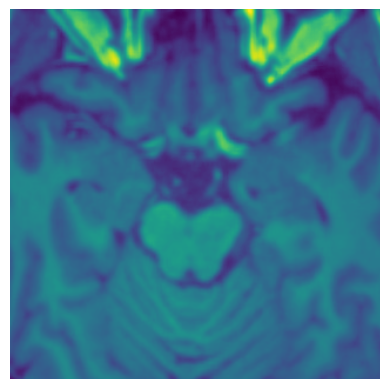

In [6]:
cropped_image = scale_image(image_np, 2, 2)

plt.figure()
plt.imshow(cropped_image)
plt.axis('off')
plt.show()

## Rotation

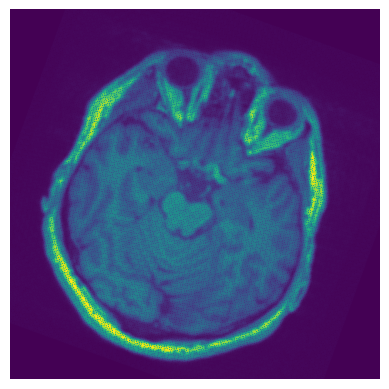

In [71]:
def rotate_image(image, angle):
    height, width = image.shape
    
    rotated_image = np.zeros_like(image)
    
    # konversi ke radian
    angle_rad = np.radians(angle)
    
    # koordinat tengah gambar
    center_x, center_y = width // 2, height // 2

    # matriks rotasi
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ], dtype=np.float32)

    for x in range(width):
        for y in range(height):
            # pindah origin ke tengah
            new_x = x - center_x
            new_y = y - center_y
            
            # terapkan transformasi
            new_coords = np.dot([new_x, new_y], rotation_matrix)
            rotated_x, rotated_y = new_coords
            
            # kembalikan origin
            rotated_x = int(rotated_x + center_x)
            rotated_y = int(rotated_y + center_y)
            
            # terapkan pixel jika masuk dalam frame gambar
            if 0 <= rotated_x < width and 0 <= rotated_y < height:
                rotated_image[rotated_x, rotated_y] = image[x, y]
    
    return rotated_image

rotated_image = rotate_image(image_np, 20)

plt.figure()
plt.imshow(rotated_image)
plt.axis('off')
plt.show()

## Flipping

In [58]:
def horizontal_flip(image_array):
    """
    Flip an image horizontally using matrix multiplication.
    
    Parameters:
    image_array (numpy.ndarray): Input image as a numpy array.
    
    Returns:
    numpy.ndarray: Horizontally flipped image.
    """
    # Create the horizontal flip transformation matrix
    transform_matrix = np.array([[-1, 0, image_array.shape[1] - 1],
                                 [0, 1, 0],
                                 [0, 0, 1]])
    
    # Initialize the flipped image array
    flipped_image = np.zeros_like(image_array)
    
    # Apply the transformation
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            new_coords = transform_matrix @ np.array([j, i, 1])
            flipped_image[i, j] = image_array[int(new_coords[1]), int(new_coords[0])]
    
    return flipped_image

def vertical_flip(image_array):
    """
    Flip an image vertically using matrix multiplication.
    
    Parameters:
    image_array (numpy.ndarray): Input image as a numpy array.
    
    Returns:
    numpy.ndarray: Vertically flipped image.
    """
    # Create the vertical flip transformation matrix
    transform_matrix = np.array([[1, 0, 0],
                                 [0, -1, image_array.shape[0] - 1],
                                 [0, 0, 1]])
    
    # Initialize the flipped image array
    flipped_image = np.zeros_like(image_array)
    
    # Apply the transformation
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            new_coords = transform_matrix @ np.array([j, i, 1])
            flipped_image[i, j] = image_array[int(new_coords[1]), int(new_coords[0])]
    
    return flipped_image

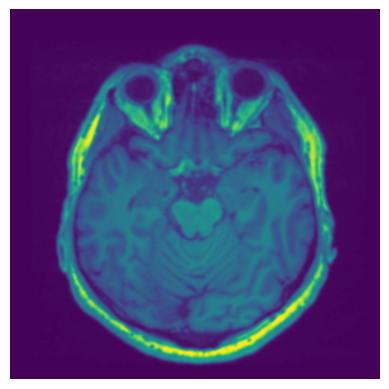

In [59]:
vertical_flipped_image = horizontal_flip(image_np)

plt.figure()
plt.imshow(vertical_flipped_image)
plt.axis('off')
plt.show()

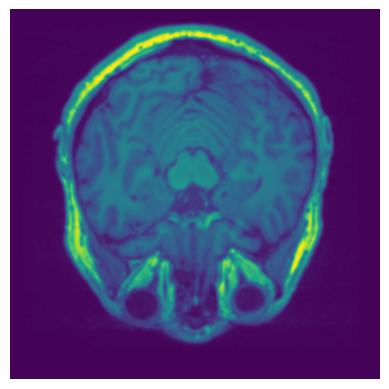

In [60]:
horizontal_flipped_image = vertical_flip(image_np)

plt.figure()
plt.imshow(horizontal_flipped_image)
plt.axis('off')
plt.show()

## Implementasi Image Augmentation

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import random

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, root_path, batch_size, folder_names, rotate=0, scale_x=1, scale_y=1, shear_factor=0, augmentation = True):
        self.root_path = root_path
        self.batch_size = batch_size
        self.folder_names = folder_names
        self.rotate = rotate
        self.scale_x = scale_x
        self.scale_y = scale_y
        self.shear_factor = shear_factor
        self.image_shape = (150, 150, 1)  # Update sesuai kebutuhan
        self.augmentation = augmentation

        # Create a mapping from folder names to label indices
        self.label_map = {folder: idx for idx, folder in enumerate(folder_names)}

        # Collect all image paths and their labels
        self.image_paths = []
        self.labels = []
        for category in folder_names:
            category_dir = os.path.join(root_path, category)
            files = os.listdir(category_dir)
            for file in files:
                img_path = os.path.join(category_dir, file)
                self.image_paths.append(img_path)
                self.labels.append(self.label_map[category])

    def __len__(self):
        if self.augmentation:
            return (len(self.image_paths) * 2) // self.batch_size
        else:
            return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        if self.augmentation:
            indices = list(range(index * self.batch_size // 2, (index + 1) * self.batch_size // 2))
            batch_image_paths = [self.image_paths[i % len(self.image_paths)] for i in indices]
            batch_labels = [self.labels[i % len(self.labels)] for i in indices]
        else:
            batch_image_paths = self.image_paths[index * self.batch_size: (index + 1) * self.batch_size]
            batch_labels = self.labels[index * self.batch_size: (index + 1) * self.batch_size]

        images = []
        labels = []

        for img_path, label in zip(batch_image_paths, batch_labels):
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            image_np = np.array(image)

            # Add original image
            images.append(image_np)
            labels.append(label)
            
            # Augmentation
            if self.augmentation:
                aug_image_np = self._augment_image(image_np)
                images.append(aug_image_np)
                labels.append(label)
            
        # Preprocess images and normalize
        images = [self._preprocess_image(img) for img in images]
        images = np.array(images)
        labels = tf.keras.utils.to_categorical(labels, num_classes=len(self.folder_names))

        return images, labels
    
    def _augment_image(self, image_np):
        num = random.randint(1, 5)
        if num == 1:
            image_np = vertical_flip(image_np)
        elif num == 2:
            image_np = horizontal_flip(image_np)
        elif num == 3:
            image_np = rotate_image(image_np, random.uniform(0, self.rotate))
        elif num == 4:
            image_np = scale_image(image_np, random.uniform(1, self.scale_x), random.uniform(1, self.scale_y))
        elif num == 5:
            image_np = shear_image(image_np, random.uniform(0, self.shear_factor), random.uniform(0, self.shear_factor))
        return image_np

    def _preprocess_image(self, image_np):
        pil_image = Image.fromarray(image_np)
        pil_image = pil_image.resize((150, 150))
        reshaped_image_array = np.array(pil_image).reshape(self.image_shape) / 255.0  # Normalize the image
        return reshaped_image_array

In [ ]:
base_dir = "./Dataset"
folder_names = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

root_path = "./SplitDataset/train"
train_datgen = CustomDataGenerator(root_path, batch_size=8, folder_names=folder_names)
root_path = "./SplitDataset/val"
val_datgen = CustomDataGenerator(root_path, batch_size=8, folder_names=folder_names, augmentation=False)

# Modelling

In [ ]:

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(len(folder_names), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
EPOCHS = 5

aug_model = create_model()
history = aug_model.fit(
    train_datgen,
    epochs=EPOCHS,
    steps_per_epoch=len(train_datgen),
    validation_data=val_datgen,
    validation_steps=len(val_datgen)
)

Epoch 1/5
338/338 [==============================] - 173s 510ms/step - loss: 2.5808 - accuracy: 0.1616 - val_loss: 2.2854 - val_accuracy: 0.2072
Epoch 2/5
338/338 [==============================] - 168s 496ms/step - loss: 2.2255 - accuracy: 0.3399 - val_loss: 1.9212 - val_accuracy: 0.4366
Epoch 3/5
338/338 [==============================] - 170s 503ms/step - loss: 1.7440 - accuracy: 0.4889 - val_loss: 1.3554 - val_accuracy: 0.5976
Epoch 4/5
338/338 [==============================] - 171s 507ms/step - loss: 1.2900 - accuracy: 0.6150 - val_loss: 0.9420 - val_accuracy: 0.7346
Epoch 5/5
338/338 [==============================] - 178s 525ms/step - loss: 0.9334 - accuracy: 0.7163 - val_loss: 0.7154 - val_accuracy: 0.8134


In [ ]:
aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 64)       

In [ ]:
root_path = "./SplitDataset/train"
no_aug_train_datgen = CustomDataGenerator(root_path, batch_size=8, folder_names=folder_names, augmentation=False)

EPOCHS = 5

no_aug_model = create_model()
no_aug_history = no_aug_model.fit(
    no_aug_train_datgen,
    epochs=EPOCHS,
    steps_per_epoch=len(no_aug_train_datgen),
    validation_data=val_datgen,
    validation_steps=len(val_datgen)
)

Epoch 1/10
169/169 [==============================] - 8s 45ms/step - loss: 2.6178 - accuracy: 0.1731 - val_loss: 2.4159 - val_accuracy: 0.1901
Epoch 2/10
169/169 [==============================] - 8s 45ms/step - loss: 2.4641 - accuracy: 0.1916 - val_loss: 2.2459 - val_accuracy: 0.2945
Epoch 3/10
169/169 [==============================] - 8s 45ms/step - loss: 2.2315 - accuracy: 0.3055 - val_loss: 1.9514 - val_accuracy: 0.4966
Epoch 4/10
169/169 [==============================] - 8s 45ms/step - loss: 1.7664 - accuracy: 0.4882 - val_loss: 1.3248 - val_accuracy: 0.6421
Epoch 5/10
169/169 [==============================] - 8s 46ms/step - loss: 1.2693 - accuracy: 0.6072 - val_loss: 0.9916 - val_accuracy: 0.7380
Epoch 6/10
169/169 [==============================] - 8s 45ms/step - loss: 0.8696 - accuracy: 0.7448 - val_loss: 0.8476 - val_accuracy: 0.7295
Epoch 7/10
169/169 [==============================] - 8s 45ms/step - loss: 0.5850 - accuracy: 0.8240 - val_loss: 0.5624 - val_accuracy: 0.8373

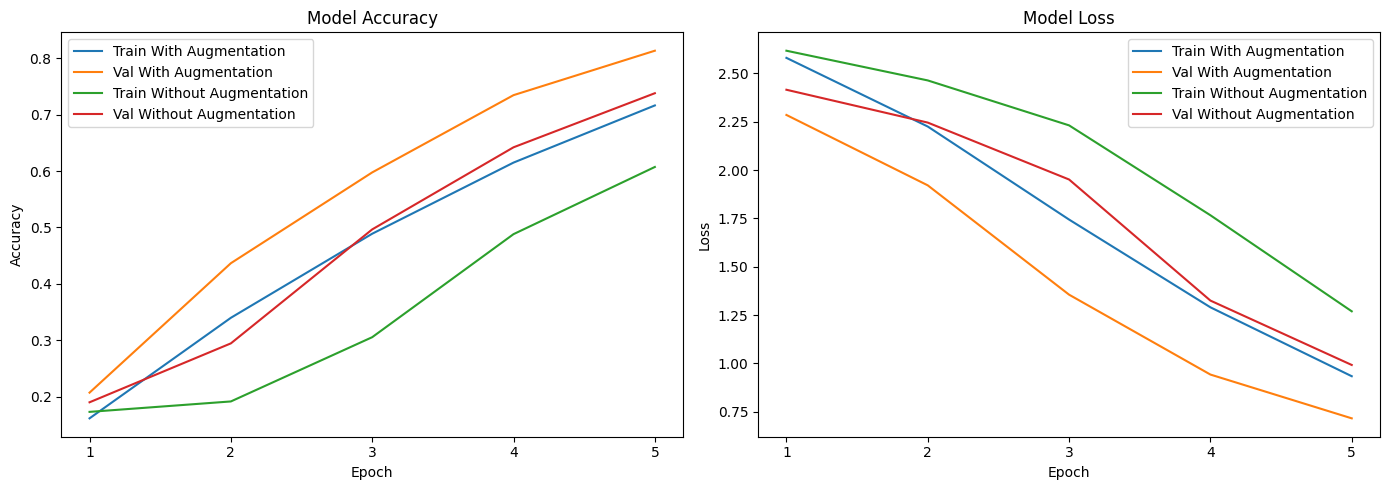

In [ ]:
import matplotlib.pyplot as plt

# Plot the training history
def plot_history(histories, titles, epochs=5):
    plt.figure(figsize=(14, 5))

    for i, history in enumerate(histories):
        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'][:epochs], label=f'Train {titles[i]}')
        plt.plot(history.history['val_accuracy'][:epochs], label=f'Val {titles[i]}')
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.xticks(range(epochs), range(1, epochs + 1))
        plt.legend(loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'][:epochs], label=f'Train {titles[i]}')
        plt.plot(history.history['val_loss'][:epochs], label=f'Val {titles[i]}')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.xticks(range(epochs), range(1, epochs + 1))
        plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the histories
plot_history([history, no_aug_history], ['With Augmentation', 'Without Augmentation'], epochs=5)